# 10/May/2022 
# Data Mining final Project: Molecular energy prediction

For the project you are going to work in groups of 2.

## Aim
In this project you are going to work with molecular data and you have to predict the electronic energy of the coordinates (Energy_)  and the free energy corrected energy at room temperature (Energy DG).

## Data Description
The given dataset (data.csv) consists of  a set of formatted values for $10.000$ molecules/SMILES but for each molecule there are more than one coordinate set. This results in multiple descriptors and energies for each molecule. For your analysis you should use only the instance with the lowest energy (Energy_) per input molecule.



The dataset consists of the following attributes:

- The simplified molecular-input line-entry system (SMILES) for the input molecules 

	- Chiral\_Molecular\_SMILES  - This is the fully defined SMILES for the molecule
    
- the following energy values:
	- Energy\_(kcal/mol) - This is the electronic energy of the coordinates (target1)
	- Zero\_point\_energy\_(kcal/mol@0K) - This is the thermal correction at 0 K. It accounts for vibrations of the molecule
	- Enthalpy\_(kcal/mol@298K) - This is the thermal correction at room temperature. It accounts for the population of vibrational states at this 	temperature
	- Gibbs\_energy\_(kcal/mol@298K) - This is the thermal correction including entropy at room temperature
	- Energy DG (kcal/mol) - This is the sum of Energy and Gibbs\_energy,i.e. free energy corrected energy at room temperature (target2)
    
-  electronic descriptors derived from quantum chemistry:
	- Core\_Core\_Repulsion\_(kcal/mol) -  The interaction energy of the nuclei     
	- Core\_Hamiltonian\_(kcal/mol) - Interaction of 1 electron with each orbital summed
	- Two\_Electron\_Integral\_(kcal/mol) - interaction of 2 electrons with the nuclei and each other  
	- Electronic\_Energy\_(kcal/mol) Heat\_of\_Formation\_ (kcal/mol) - All interactions considered
	- HOMO\_Energy\_\_(eV) -  The potential of the highest orbital with electrons (Highest Occupied Molecular Orbital)
	- LUMO\_Energy\_(eV) - The potential of the lowest unoccupied orbital  
	- H-L\_Gap\_(eV) - The difference in these values already computed
    
- [3D descriptors directly from RDKit](https://www.rdkit.org/docs/source/rdkit.Chem.Descriptors3D.html):
	- PMI1
	- PMI2
	- PMI3
	- NPR1
	- NPR2
	- Radius\_of\_Gyration
	- Inertial\_Shape\_Factor Spherocity\_Index 
	- Asphericity
	- Eccentricity


## Model

You are free to chose the representation of the data that you are going to use. If you want to work with one-hot-encoding data (see project.pdf for details) you can find the code to convert a single smile string to a one-hot encoding in `smile_to_hot()` function at `utils.py`.
 You can even use as input data different properties and descriptors (number of bonds,  number of atoms,  number of C, number of O e.t.c. )  that you can extract from your data  manually or using RDKit.  (The properties that we mention are random examples,  there are much more properties and descriptors for the molecules and you have to think what it makes sense for you to use). 

You are free to try different approaches and models,  you can use ready libraries for your algorithm. The main focus is to see the model you have come up but also the other approaches that you tried. You have to understand deeply all the algorithms that you have tried. 



After cleaning the data, using load\_data() function in utils.py split the data into train and test.  Use **cross-validation** and to select the best model based on **statistical significant test**.  Only for the best model you will use the test data (of course you have to include in your report and present all the models that you have tried).  **It is mandatory to use three or more different algorithms in addition to a baseline**. 

(The baseline is the naive baseline algorithm,  providing context on just how good a given method actually is.)


The final model we would expect is a model that can work on universal data,  which means it can give a reasonable prediction on different molecular datasets.
 


## Report
You have to submit a formal report .  Your report has to include the approaches that you followed and main results not only for your final model but for all the models you have tried. We want a full picture of what exactly you have done and how. You should also discuss the different performances you have with your methods and explain why these work or not. What is important is to show us that you have a good understanding of the problem and of how to model it, what are the problems you encountered and how you solved them.


Note that this is an open project, you can try many different approaches as long as they make sense to get the best performance (creative ideas are always welcome).

## Final submission
For your final submission you have to submit on Moodle a folder named using your names (ex. NAME1_NAME2_DM_project) which should include your code (all the scripts), the dataset and your report (the report should also be saved using your names: NAME1_NAME2_DM_project.pdf).  If the size of your submission is big you can upload your submission on [SWITCH drive](https://www.switch.ch) and put on Moodle the shared link. 

## Installation Instructions
Below you will find some instructions about how to install some packages that required for the project through Conda.

[Conda](https://docs.conda.io/en/latest/) is a package manager that works on all the popular operating systems. If you do not already have it installed (e.g. through Anaconda) you can install it via Miniconda by following the instructions [here](https://docs.conda.io/en/latest/miniconda.html) -- it doesn't matter which version of Python you pick at this stage.  We can then setup the particular environment  using the [Conda yml file](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#creating-an-environment-from-an-environment-yml-file) I put in the folder of the project.


Assuming you have Conda installed,  install the environment by:

1. `conda env create -f DM_project_env.yml`
2. `conda activate DM_project`
3. And then finally check it worked correctly by running \$ `conda env list`

To **activate your enviroment** type: `$ conda activate DM_project`
and to deactivete it you should type `$ conda deactivate`




In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt


In [2]:
# import the parts of RDKit that we need
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit import DataStructs
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdDepictor, rdMolDescriptors


from rdkit.Chem.Draw import IPythonConsole


import time
rdDepictor.SetPreferCoordGen(True)
print(rdkit.__version__)


2020.03.1


If get an error runing the previous cell 
- first check that you have installed correctly your enviroment (check if you can see it if you type in your termilal `$ conda env list`). 
- If the enviroment is installed correctly make sure that you have activated it (`$ conda activate DM_project`) before you opened the jupyter notebook.


##  Reading in SMILES strings

SMILES (Simplified molecular-input line-entry system) proposed by Weininger (1988) is a popular method to represent molecules as ASCII strings. The string is created by printing out the nodes found on a traversal of the molecular graph. The idea behind is to use simple line notations for chemical formulas that are based on some rules.


Atoms of chemical elements are represented by chemical symbols in capital letter, hydrogen is usually ignored. Single bonds are not displayed; for double, triple and quadruple bonds we shall use '=', '#', '$' respectively. Atoms that are bonded must stand nearby. Ring structures are written by breaking each ring at an arbitrary point (although some choices will lead to a more legible SMILES than others) to make a 'straight non-ring' structure (as if it wasn't a ring) and adding numerical ring closure labels to show connectivity between non-adjacent atoms. Aromacity is commonly illustrated by writing the constituent B, C, N, O, P and S atoms in lower-case forms b, c, n, o, p and s, respectively.

SMILES are typically first converted into a one-hot based representation. The representation of a molecule through a SMILE string is not unique and the non- uniqueness of SMILES arises from a fundamental ambiguity about which atom to start the SMILES string construction. However, it is possible to transform a smile into canonical form (using specific tools such as RDKit).


## RDKit


RDKit is a collection of cheminformatics and machine learning tools written in C++ and Python. It allows to work with many representations of chemical data and has a power to extract almost each chemical descriptor from the data you have. 

More Informations about how to use RDKit and examples, you can find in the [RDKit documentation](http://www.rdkit.org/docs/index.html).





### Using RDKit

Let's start by defining a string variable containing the SMILES representation of the paracetemol (i.e. acetaminophen) molecule, a popular painkiller and reading it into RDKit.


### Visualization of molecules

In order to visualize the the SMILES we have to convert them to molecules. This happened running `Chem.MolFromSmiles`.



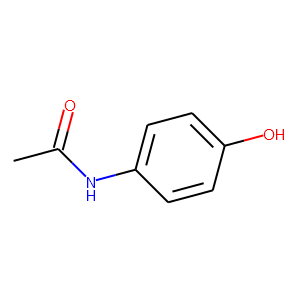

In [3]:
paracetemol_str = 'CC(=O)Nc1ccc(O)cc1'

# convert smile to mol
paracetemol_mol = Chem.MolFromSmiles(paracetemol_str)

# visualize mol
Draw.MolToImage(paracetemol_mol)

Once we have converted the SMILES to a RDKit `Mol` object (which happened when running `Chem.MolFromSmiles`) we can manipulate it in different ways. For example, we can iterate through the atoms or bonds:

In [4]:
# Iterate through the atoms. Print their symbol,  atomic number, and number of Hydrogens
for atm in paracetemol_mol.GetAtoms():
    print(f"Atom element: {atm.GetSymbol()}, atomic number: {atm.GetAtomicNum()}, number of hydrogens {atm.GetTotalNumHs()}")

    
print("\n\n")


# Iterate through the bonds
for bnd in paracetemol_mol.GetBonds():
    print(f"Bond from {bnd.GetBeginAtomIdx()} to {bnd.GetEndAtomIdx()} and is of type {bnd.GetBondType()}.")


Atom element: C, atomic number: 6, number of hydrogens 3
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: O, atomic number: 8, number of hydrogens 0
Atom element: N, atomic number: 7, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 0
Atom element: O, atomic number: 8, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1
Atom element: C, atomic number: 6, number of hydrogens 1



Bond from 0 to 1 and is of type SINGLE.
Bond from 1 to 2 and is of type DOUBLE.
Bond from 1 to 3 and is of type SINGLE.
Bond from 3 to 4 and is of type SINGLE.
Bond from 4 to 5 and is of type AROMATIC.
Bond from 5 to 6 and is of type AROMATIC.
Bond from 6 to 7 and is of type AROMATIC.
Bond from 7 to 8 and is of type SINGLE.
Bond from 7 to 9 and is of type AROMATIC.
Bo

Note that when we iterated through the atoms we also printed the number of hydrogen atoms attached. You may have spotted that these hydrogen atoms were not included in the original SMILES string. In general we ignore the hydrogen atoms (they are treated implicitly) but we can include them in SMILES strings if we wanted:

In [5]:
print(Chem.MolToSmiles(paracetemol_mol, allHsExplicit=True))

[CH3][C](=[O])[NH][c]1[cH][cH][c]([OH])[cH][cH]1


### Numbers of atoms of molecule

The size of a molecule can be approximated by a number of atoms in it. Let's extract corresponding values from MOL. RDkit provides GetNumAtoms() 

Number of total atoms in paracetamol : 20
Number of atoms in paracetamol (excluding H): 11


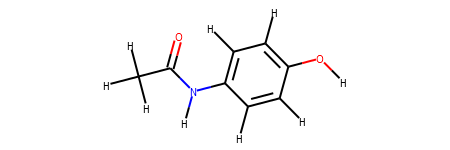

In [6]:
# AddHs function adds H atoms to a MOL (as Hs in SMILES are usualy ignored)
# GetNumAtoms() method returns a general nubmer of all atoms in a molecule including H


paracetemol_mol_with_H = Chem.AddHs(paracetemol_mol)

print('Number of total atoms in paracetamol :', paracetemol_mol_with_H.GetNumAtoms())
print('Number of atoms in paracetamol (excluding H):', paracetemol_mol.GetNumAtoms())

paracetemol_mol_with_H

### Descriptors
A number of general molecular descriptors that can also be used to featurize a molecule are provided by `rdkit.Chem.Descriptors` and `rdkit.Chem.rdMolDescriptors`. Bellow we can see some examples. More examples and a detailed descripton you can find in **RDKit** documantation.



In [7]:
# Descriptors.HeavyAtomCount returns a nubmer of all atoms in a molecule with molecular weight > 1
# Descriptors.HeavyAtomMolWt the average molecular weight of the molecule ignoring hydrogens
# Descriptors.MolLogP returns the Octanol-water partition coefficient
# Descriptors.qed returns the drug-likeness 
# Descriptors.MolW returns the Molecular weight
# Descriptors.NumRotatableBonds returns the number of rotatable bond
# ...

desc_HeavyAtomCount = Descriptors.HeavyAtomCount(paracetemol_mol)
desc_HeavyAtomMolWt = Descriptors.HeavyAtomMolWt(paracetemol_mol)
desc_MolLogP = Descriptors.MolLogP(paracetemol_mol)
desc_qed = Descriptors.qed(paracetemol_mol)
desc_MolWt = Descriptors.MolWt(paracetemol_mol)
desc_NumRotatableBonds = Descriptors.NumRotatableBonds(paracetemol_mol)

print('Number of heavy atoms in paracetamol:', desc_HeavyAtomCount)
print('Average molecular weight ignoring hydrogens:', desc_HeavyAtomMolWt)

print('logP in paracetamol:', desc_MolLogP)
print('drug-likeness:', desc_qed)
print('Molecular weight:', desc_MolWt)


# rdMolDescriptors.CalcNumRings returns the number of rings for a molecule
# rdMolDescriptors.CalcNumHBD returns the number of H-bond donors for a molecule
# rdMolDescriptors.CalcNumHBA returns the number of H-bond acceptors for a molecule
# ...

num_rings = rdMolDescriptors.CalcNumRings(paracetemol_mol)
num_H_donors = rdMolDescriptors.CalcNumHBD(paracetemol_mol)
num_H_acceptors = rdMolDescriptors.CalcNumHBA(paracetemol_mol)

print('Number of ring:', num_rings)
print('Number of H-bond donors:', num_H_donors)
print('Number of H-bond acceptors:', num_H_acceptors)



Number of heavy atoms in paracetamol: 11
Average molecular weight ignoring hydrogens: 142.093
logP in paracetamol: 1.3505999999999998
drug-likeness: 0.5950261967780849
Molecular weight: 151.165
Number of ring: 1
Number of H-bond donors: 2
Number of H-bond acceptors: 2


## Defining and viewing a set of example molecules


In [8]:
naphthalene = Chem.MolFromSmiles('c12ccccc1cccc2')
benzoxazole = Chem.MolFromSmiles('n1c2ccccc2oc1')
indane = Chem.MolFromSmiles('c1ccc2c(c1)CCC2')
skatole = Chem.MolFromSmiles('CC1=CNC2=CC=CC=C12')
benzene = Chem.MolFromSmiles('c1ccccc1')
quinoline = Chem.MolFromSmiles('n1cccc2ccccc12')

my_molecules = [naphthalene, 
                benzoxazole,
                indane,
                skatole,
                benzene,
                quinoline,
               ]

It's easy to get a look at the structure of these molecules.



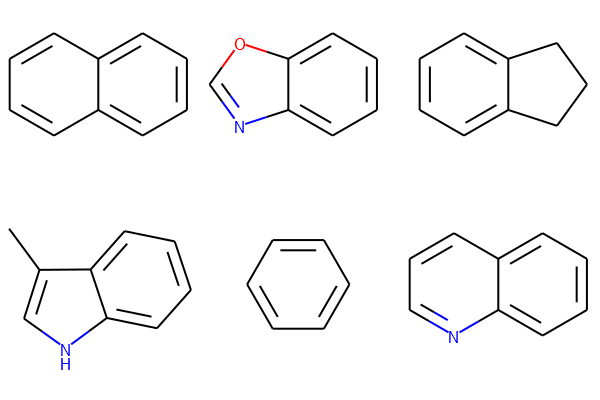

In [9]:
Draw.MolsToGridImage(my_molecules)


# Importing  the dataset

In [3]:
from utils import *

In [4]:
file_data = './dataset/data.csv'


## Quick view of data

In [149]:
df = pd.read_csv(file_data)
df = df.dropna()

In [150]:
df.head()

,Chiral_Molecular_SMILES,Energy_(kcal/mol),Zero_point_energy_(kcal/mol@0K),Enthalpy_(kcal/mol@298K),Gibbs_energy_(kcal/mol@298K),Energy DG:kcal/mol),PMI1,PMI2,PMI3,NPR1,...,Asphericity,Eccentricity,Core_Core_Repulsion_(kcal/mol),Core_Hamiltonian_(kcal/mol),Two_Electron_Integral_(kcal/mol),Electronic_Energy_(kcal/mol),Heat_of_Formation_(kcal/mol),HOMO_Energy__(eV),LUMO_Energy_(eV),H-L_Gap_(eV)
0,Fc1ccc(cc1)c1cn[nH]c1N,-51177.14356,93.711236,101.010221,72.646019,-51104.49754,15.116918,1138.689784,1276.446124,0.152023,...,0.611914,0.988377,209590.8432,-82616.31512,-356305.3370,-260768.9836,19.369701,-0.325429,-0.006221,0.319207
1,Fc1ccc(cc1)c1cn[nH]c1N,-51177.14356,93.716622,101.010607,72.676293,-51104.46727,55.760384,2320.928165,2603.438182,0.277877,...,0.386631,0.960616,423156.7216,-118968.29190,-755464.2531,-496700.4184,-63.125192,-0.357174,-0.031290,0.325884
2,O=C(c1ccccc1)O[C@H]1c2ccccc2C(=O)N1C,-73542.31526,150.283189,161.552872,122.934889,-73419.38037,16.723606,1358.577969,1573.221539,0.161400,...,0.592709,0.986863,202454.7033,-81529.04355,-343358.5290,-253208.3080,11.846054,-0.326917,-0.027046,0.299870
3,O=C(c1ccccc1)O[C@H]1c2ccccc2C(=O)N1C,-73542.31444,150.296914,161.555511,123.082139,-73419.23230,35.725474,1045.051233,1174.934149,0.400795,...,0.235944,0.914903,350422.3801,-94499.59329,-629142.5208,-409070.8537,-94.228188,-0.342692,0.007355,0.350046
4,O=C(c1ccccc1)O[C@@H]1c2ccccc2C(=O)N1C,-73542.31445,150.299719,161.554575,123.129949,-73419.18450,38.861689,1717.118190,1838.665112,0.270299,...,0.402459,0.962733,343048.4259,-101348.46490,-609028.2103,-405862.5701,-38.218309,-0.364205,-0.010251,0.353954


In [151]:
print("Total number of data = " , df.shape[0])

Total number of data =  10167


## Smiles

In [8]:
# get smiles, alphabet and length of largest molecule in SMILES from the dataset
smiles, alphabet, largest_molecule_len = get_smiles_encodings(file_data)

In [9]:
print('alphabet:', alphabet)
print('length of the alphabet:', len(alphabet))
print('length of largest molecule:',largest_molecule_len)
print('some smiles:', smiles[2443:2449])

alphabet: ['r', '\\', 'l', 'I', '[', ']', 'n', '+', ')', '1', 'c', '3', '4', 'O', '#', 'H', '2', '=', '/', 'P', 'S', '(', '@', '-', 'C', 'B', 'F', 'o', 'N', 's', ' ']
length of the alphabet: 31
length of largest molecule: 68
some smiles: ['CCCBr' 'CCCBr' 'CCCBr' 'CCCCOC(=O)CC(=O)OCCCC' 'CCCCOC(=O)CC(=O)OCCCC'
 'CCCCOC(=O)CC(=O)OCCCC']


## One Hot Encoding

One-hot encoding is a sparse way of representing data in a binary string in which only a single bit can be 1, while all others are 0. In the case of molecular graphs represented as a string, one-hot-encoding consists of encoding each character of the string with a binary vector.


In [10]:
# Convert a single smile string to a one-hot encoding
idx = 1245
print(smiles[idx])
integer_encoded, onehot_smile = smile_to_hot(smiles[idx], largest_molecule_len, alphabet)

OCC([N+](=O)[O-])(CO)CO


In [11]:
onehot_smile.shape

(68, 31)

smile string: OCC([N+](=O)[O-])(CO)CO
one-hot encoded smile: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]]


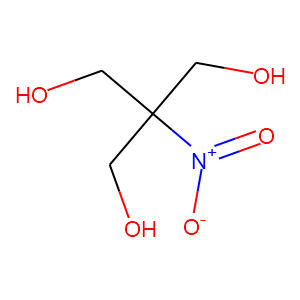

In [12]:
print('smile string:', smiles[idx])
print('one-hot encoded smile:', onehot_smile)


mol = Chem.MolFromSmiles(smiles[idx])

Draw.MolToImage(mol)

## Split the data 
 Split the data to train test (after cleaning the data)
 

In [188]:
# Split data to train and test
data_ = np.asanyarray(df)
train, test = load_data(data_)
print('train shape:', train.shape)
print('test shape:', test.shape)


train shape: (7116, 24)
test shape: (3051, 24)


-55840.68284013904
0.2502787899388286


(array([   7.,   24.,   40.,  194.,  542., 1183., 1071., 1565., 1712.,
        1557., 1193.,  680.,  249.,  123.,   27.]),
 array([-108619.3796, -102177.14145, -95734.9033, -89292.66515, -82850.427,
        -76408.18885, -69965.9507, -63523.71255, -57081.4744, -50639.23625,
        -44196.9981, -37754.75994999999, -31312.521800000002,
        -24870.283649999998, -18428.045499999993, -11985.80735],
       dtype=object),
 <BarContainer object of 15 artists>)

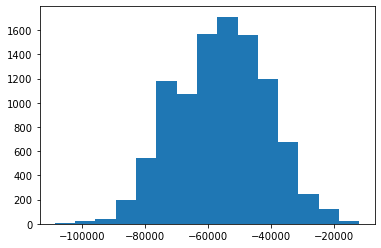

In [186]:
m = np.mean(train[:,1])
err = np.mean(np.abs((test[:,1]-m)/test[:,1]))
print(m)
print(err)
plt.hist(data_[:,1],15)

In [189]:
from sklearn import svm
from sklearn import linear_model
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

regr = linear_model.Lasso(alpha=0.1)
#regr = svm.SVR()
y_train = train[:,1]
X_train = train[:,4:]
pca.fit(X_train)



y_test = test[:,1]
X_test = test[:,4:]


X_trans = pca.transform(X_train)
X_tran = pca.transform(X_test)
(X_trans,y_train,m,s) = normalise(X_trans,y_train)
(X_tran,a,b,c) = normalise(X_tran,0)
regr.fit(X_trans,y_train)
pred = regr.predict(X_tran)

pred = pred*s+m

err = np.mean(np.abs((pred-y_test)/y_test))
print(err)

0.02905927180930207


C:\Users\amanm\Anaconda3\envs\DM_project\lib\site-packages\sklearn\decomposition\_pca.py:593: RuntimeWarning: overflow encountered in square
  self.explained_variance_ = (S ** 2) / (n_samples - 1)
C:\Users\amanm\Anaconda3\envs\DM_project\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\amanm\Anaconda3\envs\DM_project\lib\site-packages\sklearn\decomposition\_pca.py:595: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = self.explained_variance_ / total_var.sum()
C:\Users\amanm\Anaconda3\envs\DM_project\lib\site-packages\sklearn\decomposition\_pca.py:599: RuntimeWarning: invalid value encountered in double_scalars
  self.noise_variance_ = total_var.sum() - self.explained_variance_.sum()
C:\Users\amanm\Anaconda3\envs\DM_project\lib\site-packages\numpy\core\_methods.py:233: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\ama